In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

import qiskit
from qiskit_experiments import library
import qiskit.quantum_info as qi
from qiskit.circuit.library import XGate, YGate, ZGate, U1Gate
from qiskit.quantum_info import Choi, Kraus
#import qiskit.aqua.utils as utils
from qiskit.tools.monitor import job_monitor
from qiskit import QuantumCircuit, QuantumRegister,execute, Aer
import qiskit.quantum_info.operators.channel.transformations as qtrans
from qiskit_aer import AerSimulator

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
#Pauli matrices:
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])


# 2 Qubit-channel

Now we will use the algorithm to simulate a 2-qubit quantum channel. In particular, the channel we will simulate is 

$$ \varepsilon(\rho) = k_0 \rho + k_1 (\sigma_3 \otimes I) \rho (\sigma_3 \otimes I) + k_2 (I \otimes \sigma_3) \rho (I \otimes \sigma_3) . $$

with $k_0 + k_1 + k_2 = 1$. To simulate this particular channel, we will need the two principal qubits and two ancilla qubits (to create the probabilities $k_0, k_1, k_2$. 


In [22]:
"""Function to create the circuit given the values of k:"""

def ks_to_circuit(k0):
    
    theta = np.arcsin(np.sqrt(k0))
    
    #We calculate the angles theta0, theta1, theta2.
    theta0 = 2*np.arcsin(np.sqrt(k0))
    
    # We create the circuit with 3 qubits.
    qreg_q = QuantumRegister(3, 'q') 
    circ = QuantumCircuit(qreg_q)
    
    #Add the quantum gates to create the ancilla qubit state.
    circ.ry(theta0,2)
    
    #Add the controlled gates.
    czz = ZGate.control(ZGate(),num_ctrl_qubits=1,ctrl_state='1')

    #     czi = ZGate.control(ZGate(),num_ctrl_qubits=2,ctrl_state='10')
    
    
    
    
    circ.append(czz, [0, 2])
    circ.append(czz, [1, 2])

    #     circ.append(czi, [2,3, 1])

    return(circ)

circ = ks_to_circuit(0.6)
circ.draw()

q_0: ───────────────■────
                    │    
q_1: ───────────────┼──■─
     ┌────────────┐ │  │ 
q_2: ┤ Ry(1.7722) ├─■──■─
     └────────────┘

Create many instances of the channel for different values of $p_0,p_1,p_2$:

In [24]:
points = []
for k in np.arange(0,1,0.04):
    points.append(np.around(k,2))
points


[0.0,
 0.04,
 0.08,
 0.12,
 0.16,
 0.2,
 0.24,
 0.28,
 0.32,
 0.36,
 0.4,
 0.44,
 0.48,
 0.52,
 0.56,
 0.6,
 0.64,
 0.68,
 0.72,
 0.76,
 0.8,
 0.84,
 0.88,
 0.92,
 0.96]

In [26]:

circuits = []
for k in points:
    circuits.append(ks_to_circuit(k))

circuits[13].draw()


q_0: ───────────────■────
                    │    
q_1: ───────────────┼──■─
     ┌────────────┐ │  │ 
q_2: ┤ Ry(1.6108) ├─■──■─
     └────────────┘

### Run Quantum Process tomography

In [27]:
def choi_theoretical(k0):
    '''For some values of taus describing a Pauli channel, this function
    returns the choi matrix of said channel.
    
    Args:
        taus (list): The list of taus [tau1,tau2,tau3] that defines a Pauli channel.
    
    Returns:
        mat_choi (qi.choi): The choi matrix of the channel.
    '''

    
    #First we convert the taus to the ks that describe the channel.
#     k0,k1,k2 = ks
    
    #We can write the Kraus representation of the channel, using that the 
    # Kraus operators are \sqrt{k_i} \sigma_i with \sigma_i the ith Pauli matrix.
    
    k = Kraus([np.sqrt(1-k0)*np.kron(I,I),np.sqrt(k0)*np.kron(Z,Z)])
    
    #We convert the Kraus representation to the choi representation of the channel.
    mat_choi = np.array(qtrans._kraus_to_choi([k.data,None]))
    
    return(qi.Choi(mat_choi))



In [28]:
from qiskit_experiments.library import ProcessTomography
import qiskit
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeLima

In [36]:
backend = AerSimulator.from_backend(FakeLima())
# backend = Aer.get_backend('aer_simulator')

fidelities = []
for i in range(len(points)):
    print(i)
    point = points[i]
    circ = circuits[i]
    
    
    qpt = ProcessTomography(circ,backend,*measurement_indices=[0,1],
                            preparation_indices=[0,1])
    qpt.set_run_options(shots=20000)
    
    qpt_run = qpt.run()
    qptdata = qpt_run.block_for_results()
    
    
    
    choi_simu = qptdata.analysis_results("state").value
    choi_theo = choi_theoretical(point)
    
    dis =qi.diamond_norm(qi.Choi(choi_simu)-choi_theo)
    fidelities.append(1-0.5*dis)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [37]:
with open("pruebas/Resultados/fidelity-2qbit-zz.csv","w") as f:
    f.write("p,fid")
    
    for i in range(len(points)):
        f.write("\n" + str(points[i]) + "," + str(fidelities[i]))
        

In [38]:
fidelities =[]

import csv
import pandas as pd


data = pd.read_csv("pruebas/Resultados/fidelity-2qbit-zz.csv")

        
fidelities = data['fid']
fidelities = np.array(fidelities)

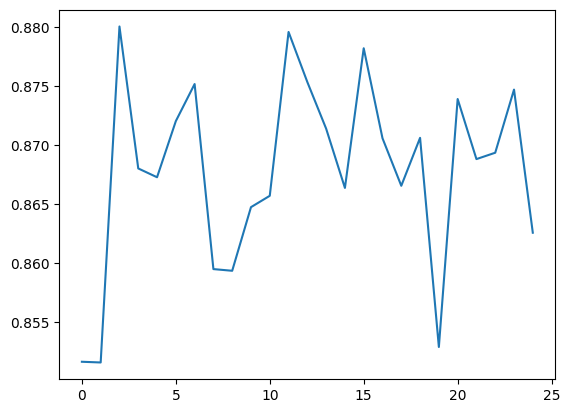

In [39]:
plt.plot(fidelities)